<div style="background: linear-gradient(to right, #6a11cb, #2575fc); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
    <h1 style="color: white; margin: 0; font-size: 2.5em; font-weight: 700;">GAICo: Evaluating Structured Outputs</h1>
    <p style="color: #e0e0e0; margin-top: 10px; font-style: italic; font-size: 1.2em; text-align: center;">Automated Plans Evaluation</p>
</div>
<br>

This notebook demonstrates a bare-bones workflow for using the GAICo (GenAI Results Comparator) library for planning.

Scenario:

1. Inputs: Travel plans which are generated using different models alongside reference plans which are known to be correct.
2. Workflow:
   - Calculate metric scores for models' responses against the reference.
   - Visualize the scores with a bar plot.

All plans used in this notebook were picked from [FABLE: A Novel Data-Flow Analysis Benchmark on Procedural Text for Large Language Model Evaluation](https://arxiv.org/abs/2505.24258).

The notebook doesn't use the usual pddl-like plans from automated planning, but instead uses travel plans, a downstream application of planning.

Author: John Aydin


## Environment Setup & Imports

The cell below adjusts `sys.path` to find the gaico module if run from examples directory. This block is primarily for local execution from the `examples/` folder if gaico is not installed.


In [1]:
import os
import sys

# Adjust sys.path to find the gaico module if run from examples directory
notebook_dir = os.getcwd()  # Get the current working directory of the notebook
# Construct the path to the project root (two levels up)
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir, os.pardir))

# Add project root to the system path if it's not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added project root to sys.path: {project_root}")

In [2]:
# Import metrics
import pandas as pd
from gaico.visualize import plot_metric_comparison

# Imports for plotting results
import numpy as np
import matplotlib.pyplot as plt

from gaico.metrics.structured import PlanningJaccard, PlanningLCS

## Example 1: Comparing a Single Plan

This example shows how to evaluate a single plan against a reference plan on multiple metrics.


In [3]:
# Sample Plans

reference_plan = "'Drive east on Elm Street.', 'Turn right onto America's Cup Avenue/RI 138A.', 'Turn left onto West Marlborough Street.', 'Turn right onto Broadway.', 'Continue for 80 meters or 11-13 seconds.', 'Your destination is on the left.'"

generated_plan = "'Drive east on Elm Street.', 'Turn right onto America's Cup Avenue/RI 138A.', 'Continue on RI 138A.', 'Turn left onto Rhode Island Avenue.', 'Turn left onto Broadway.', 'Continue for 730 meters or 58-71 seconds.', 'Your destination is on the left.'"

In [4]:
# Define metrics

jaccard_metric = PlanningJaccard()
lcs_metric = PlanningLCS()

In [5]:
jaccard_score = jaccard_metric.calculate(generated_plan, reference_plan)
lcs_score = lcs_metric.calculate(generated_plan, reference_plan)

print(f"PlanningJaccard Score: {jaccard_score}")
print(f"PlanningLCS Score: {lcs_score}")

PlanningJaccard Score: 0.3
PlanningLCS Score: 0.42857142857142855


### Example 2: Comparing Multiple Plans with Multiple Models

This example shows how to evaluate multiple plans from multiple models, and aggregate the results.


In [6]:
# Defining test cases
test_cases = [
    {
        "model_name": "Model 1",
        "generated": "'Drive east on Elm Street.', 'Turn right onto Cross Street.', 'Bear right onto Thames Street.', 'Turn left onto Coddington Street.', 'Turn right onto Charles Street.', 'Turn left onto Marlborough Street.', 'Turn right onto Broadway.', 'Continue for 80 meters or 11-13 seconds.', 'Your destination is on the left.'",
        "reference": "'Drive east on Elm Street.', 'Turn right onto America's Cup Avenue/RI 138A.', 'Turn left onto West Marlborough Street.', 'Turn right onto Broadway.', 'Continue for 80 meters or 11-13 seconds.', 'Your destination is on the left.'",
    },
    {
        "model_name": "Model 2",
        "generated": "'Drive east on Elm Street.', 'Turn right onto America's Cup Avenue/RI 138A.', 'Continue on RI 138A.', 'Turn left onto Rhode Island Avenue.', 'Turn left onto Broadway.', 'Continue for 730 meters or 58-71 seconds.', 'Your destination is on the left.'",
        "reference": "'Drive east on Elm Street.', 'Turn right onto America's Cup Avenue/RI 138A.', 'Turn left onto West Marlborough Street.', 'Turn right onto Broadway.', 'Continue for 80 meters or 11-13 seconds.', 'Your destination is on the left.'",
    },
    {
        "model_name": "Model 1",
        "generated": "'Drive northeast on Clinton Avenue West.', 'Turn right after 195 meters or 20-24 seconds.', 'Turn left after 19 meters or 7-9 seconds.', 'Turn right onto Greene Street Southeast.', 'Turn right onto Randolph Avenue Southeast.', 'Continue for 168 meters or 27-32 seconds.', 'You have arrived at your destination.'",
        "reference": "'Drive northeast on Clinton Avenue West.', 'Turn right onto Jefferson Street South.', 'Turn left onto South Side Square.', 'Turn left onto East Side Square.', 'Turn left onto North Side Square.', 'Continue for 56 meters or 11-14 seconds.', 'You have arrived at your destination.'",
    },
    {
        "model_name": "Model 2",
        "generated": "'Drive northeast on Clinton Avenue West.', 'Turn right onto Greene Street Southeast.', 'Turn right onto Randolph Avenue Southeast.', 'Continue for 168 meters or 27-32 seconds.', 'You have arrived at your destination.'",
        "reference": "'Drive northeast on Clinton Avenue West.', 'Turn right onto Jefferson Street South.', 'Turn left onto South Side Square.', 'Turn left onto East Side Square.', 'Turn left onto North Side Square.', 'Continue for 56 meters or 11-14 seconds.', 'You have arrived at your destination.'",
    },
    {
        "model_name": "Model 1",
        "generated": "'Drive west on West 7th Avenue.', 'Turn right onto South Walnut Street.', 'Turn left onto West 4th Avenue/US 160.', 'Turn right onto West Ash Street.', 'Turn left after 179 meters or 21-26 seconds.', 'Continue for 89 meters or 13-16 seconds.', 'Your destination is on the left.'",
        "reference": "'Drive east on West 7th Avenue.', 'Turn left onto South Oak Street.', 'Turn left onto West 4th Avenue/US 160.', 'Turn right onto West Ash Street.', 'Turn left after 179 meters or 21-26 seconds.', 'Continue for 89 meters or 13-16 seconds.', 'Your destination is on the left.'",
    },
    {
        "model_name": "Model 2",
        "generated": "'Drive east on West 7th Avenue.', 'Turn left onto South Oak Street.', 'Turn left onto West 4th Avenue/US 160.', 'Turn right after 47918 meters or 2072-2532 seconds.', 'Turn right after 199 meters or 20-25 seconds.', 'Continue for 395 meters or 58-70 seconds.', 'Your destination is on the right.'",
        "reference": "'Drive east on West 7th Avenue.', 'Turn left onto South Oak Street.', 'Turn left onto West 4th Avenue/US 160.', 'Turn right onto West Ash Street.', 'Turn left after 179 meters or 21-26 seconds.', 'Continue for 89 meters or 13-16 seconds.', 'Your destination is on the left.'",
    },
]

In [7]:
# Define metrics to use
jaccard_metric = PlanningJaccard()
lcs_metric = PlanningLCS()

In [8]:
results = []

# Calculate each metric for each test case.
for test_case in test_cases:
    jaccard_score = jaccard_metric.calculate(test_case["generated"], test_case["reference"])
    lcs_score = lcs_metric.calculate(test_case["generated"], test_case["reference"])

    results.extend(
        [
            {
                "model_name": test_case["model_name"],
                "metric_name": "Jaccard",
                "score": jaccard_score,
            },
            {
                "model_name": test_case["model_name"],
                "metric_name": "LCS",
                "score": lcs_score,
            },
        ]
    )

In [9]:
df = pd.DataFrame(results)
df.head()

# Optionally, save results
# df.to_csv('model_comparison.csv')

,model_name,metric_name,score
0,Model 1,Jaccard,0.363636
1,Model 1,LCS,0.444444
2,Model 2,Jaccard,0.300000
3,Model 2,LCS,0.428571
4,Model 1,Jaccard,0.166667


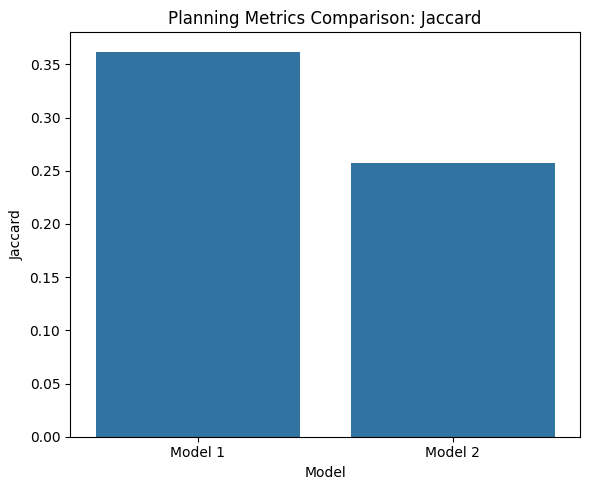

In [10]:
# Plotting aggregated Jaccard similarity results
ax = plot_metric_comparison(
    df,
    aggregate_func=np.mean,
    metric_name="Jaccard",
    title="Planning Metrics Comparison: Jaccard",
    figsize=(6, 5),
)

plt.show()

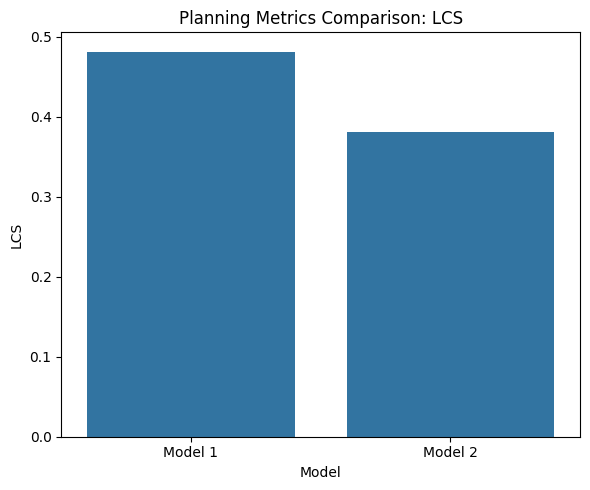

In [11]:
# Plotting aggregated LCS scores

ax = plot_metric_comparison(
    df,
    aggregate_func=np.mean,
    metric_name="LCS",
    title="Planning Metrics Comparison: LCS",
    figsize=(6, 5),
)

plt.show()